In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Extract the lat / lon for the associated grid.
basedir = '/scratch/b/b380459/icon_4_hackathon/nawdexnwp-80km-mis-0001/'
datei = xr.open_dataset(basedir + 'nawdexnwp-80km-mis-0001_2016092200_3dcloud_DOM01_ML_0024.nc')
clc = datei['clc']
heights = clc['height']
clc_m = clc.mean(dim={'time','ncells'})
clc_std = clc.std(dim={'time','ncells'})
clc_q1 = clc.quantile(0.33,dim={'time','ncells'})
clc_q3 = clc.quantile(0.66,dim={'time','ncells'})
clc_max = clc.max(dim={'time','ncells'})
clc_min = clc.min(dim={'time','ncells'})
#print(clc_min,clc_q1,clc_m,clc_q3,clc_max)

(0.0, 50.0)

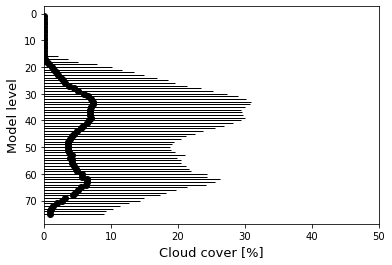

In [3]:
fs = 13
fig = plt.figure()
plt.errorbar(clc_m, heights, xerr=clc_std, fmt='ok', lw=1)
plt.gca().invert_yaxis()
plt.ylabel('Model level',fontsize=fs)
plt.xlabel('Cloud cover [%]',fontsize=fs)
plt.xlim([0,50])
#plt.errorbar(clc_m, heights, [clc_m-clc_min, clc_max-clc_m], fmt='.k', ecolor='gray', lw=1)

## Setup a distributed computing cluster (taken from Martin Bergemann)
The following can read data on the order of terabytes. We set up a distributed cluster using the dask_jobqueue library (see https://jobqueue.dask.org/en/latest/) and ultimately the *Slurm* workload manager. To generate a slurm cluster, we specify account, user, partition, etc. like we would for a bash script to submit batch jobs.

In [6]:
from getpass import getuser
from pathlib import Path
import os
from tempfile import TemporaryDirectory
from subprocess import run, PIPE
import sys

import dask # Distributed data library
from dask_jobqueue import SLURMCluster # Set up distributed memory
from distributed import Client, progress, wait # Library to orchestrate distributed resources

In [7]:
account_name = 'bb1018'
partition = 'compute'
job_name = 'hackCLC'
memory = '10GiB' # Max memory per node = 64 GiB initially
cores = 12 # Max number of cores reserved = 12 cores
walltime = '01:00:00'

In [8]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser()
# The temporary directory closes with the notebook.
dask_scratch_dir = TemporaryDirectory(dir=scratch_dir, prefix='hackathon')

# Generate a job script to be submitted via sbatch and print it.
cluster = SLURMCluster(memory=memory, cores=cores, project=account_name,
                      walltime=walltime, queue=partition, name=job_name,
                      scheduler_options={'dashboard_address': ':12345'},
                      local_directory=dask_scratch_dir.name,
                      job_extra=[f'-J {job_name}',
                                 f'-D {dask_scratch_dir.name}',
                                 f'--begin=now',
                                 f'--output={dask_scratch_dir.name}/LOG_hackathon.%j.o'],
                      interface='ib0')

print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -A bb1018
#SBATCH -n 1
#SBATCH --cpus-per-task=12
#SBATCH --mem=10G
#SBATCH -t 01:00:00
#SBATCH -J hackCLC
#SBATCH -D /scratch/b/b380873/hackathong0twt3_5
#SBATCH --begin=now
#SBATCH --output=/scratch/b/b380873/hackathong0twt3_5/LOG_hackathon.%j.o

JOB_ID=${SLURM_JOB_ID%;*}

/pf/b/b380459/conda-envs/Nawdex-Hackathon/bin/python3 -m distributed.cli.dask_worker tcp://10.50.36.87:36186 --nthreads 12 --memory-limit 10.74GB --name name --nanny --death-timeout 60 --local-directory /scratch/b/b380873/hackathong0twt3_5 --interface ib0



In [9]:
# Order 5 nodes (according to the specifications above?)
cluster.scale(5)
cluster

In [11]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          22984230   compute  hackCLC  b380873  R       6:20      1 m11256
          22984231   compute  hackCLC  b380873  R       6:20      1 m11257
          22984232   compute  hackCLC  b380873  R       6:20      1 m11344
          22984233   compute  hackCLC  b380873  R       6:20      1 m11345
          22984234   compute  hackCLC  b380873  R       6:20      1 m11473
          22983961   compute spawner-  b380873  R      16:24      1 m10343


In [12]:
# Once the resources are available, the client needs to connect to it.
dask_client = Client(cluster)
dask_client

Client Scheduler: tcp://10.50.36.87:36186 Dashboard: http://10.50.36.87:8787/status,Cluster Workers: 5 Cores: 60 Memory: 53.69 GB


## Read 3D cloud fraction values

In [49]:
# Compare cloud fraction profiles between the 80-km and 10-km simulations.
paths = {'80km' : Path('/scratch/b/b380459/icon_4_hackathon/nawdexnwp-80km-mis-0001') / 'nawdexnwp-80km-mis-0001',
         '10km' : Path('/scratch/b/b380459/icon_4_hackathon/nawdexnwp-10km-mis-0001') / 'nawdexnwp-40km-mis-0001'}
cld3dtag = '_2016092200_3dcloud_DOM01_ML_'
sims = list(paths.keys())

{'80km': PosixPath('/scratch/b/b380459/icon_4_hackathon/nawdexnwp-80km-mis-0001/nawdexnwp-80km-mis-0001'), '10km': PosixPath('/scratch/b/b380459/icon_4_hackathon/nawdexnwp-10km-mis-0001')}


In [ ]:
# Read in the run files using open_mfdataset. The wildcard indicates all time steps.
datasets = {}
for exp in sims:
    print(f'Read data from {exp}',end='\r')
    datasets[exp] = xr.open_mfdataset(str(paths[exp] / f'{cld3dtag}*.nc'))
    print()
    